The best parameters are {'C': 100000.0, 'gamma': 0.005} with a score of 0.92


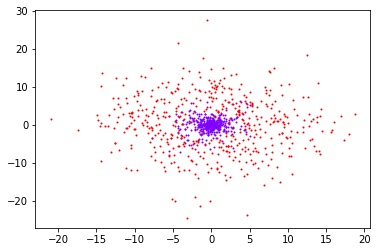

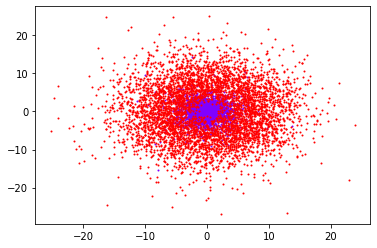

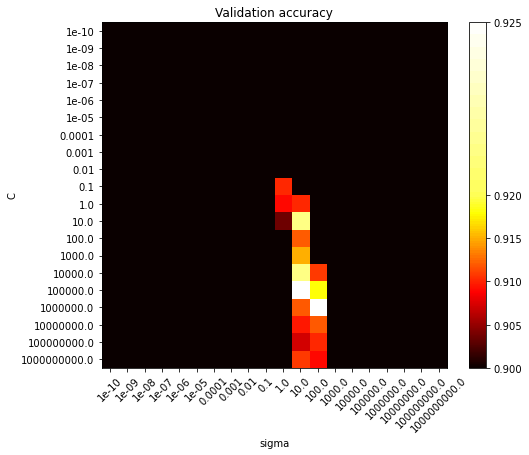

The best parameters are {'C': 100000, 'gamma': 0.006172839506172839} with a score of 0.93


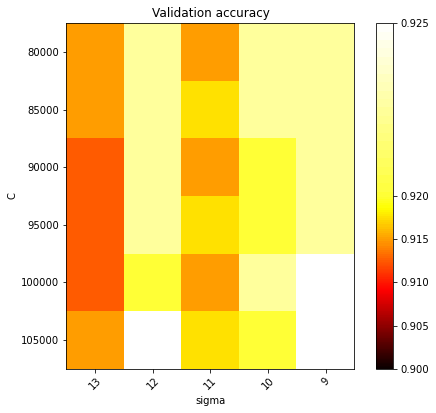

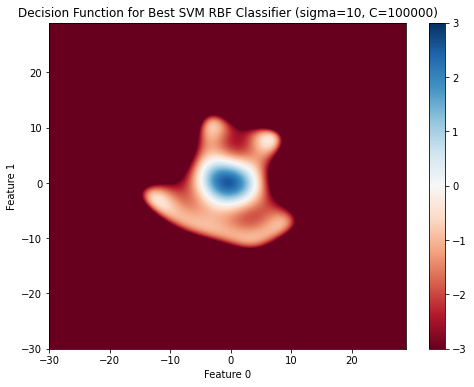

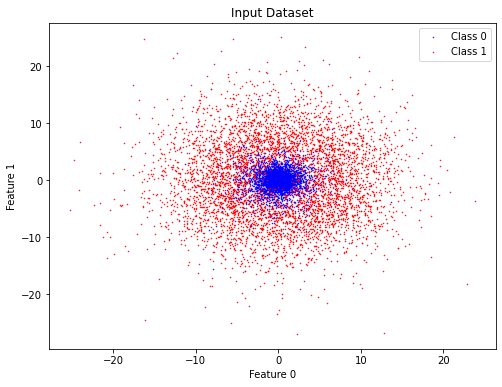

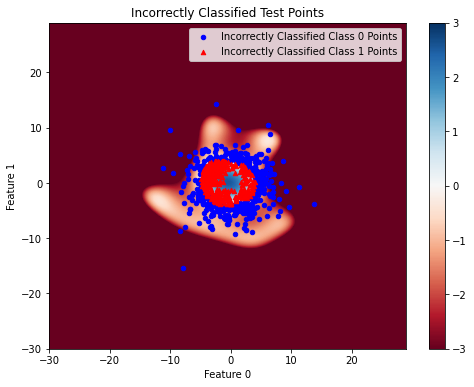

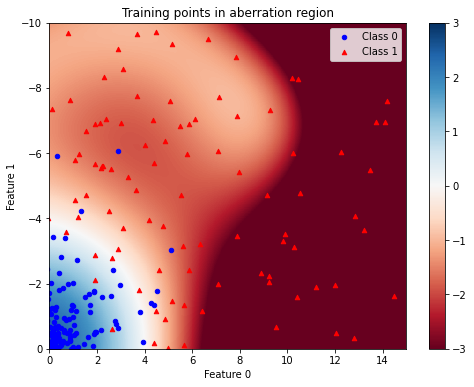

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  1 20:26:02 2021

@author: eckmb
"""

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.colors as colors

def generateMultiringDataset(numberOfClasses,numberOfSamples):
    C = numberOfClasses
    N = numberOfSamples
    
    #Generates N samples from C ring-shaped 
    #class-conditional pdfs with equal priors
    
    #Randomly determine class labels for each sample
    thr = np.linspace(0.0, 1.0, num=C+1) #split [0,1] into C equal length intervals
    u = np.random.rand(1, N) # generate N samples uniformly random in [0,1]
    labels = np.zeros((1,N))
    
    for l in range(C):
        ind_l = np.where((thr[l]<u) & (u<=thr[l+1]))
        labels[ind_l] = np.tile(l,(1,len(ind_l[0])))
    
    # parameters of the Gamma pdf needed later
    a = [pow(i, 2.5) for i in list(range(1,C+1))]
    b = np.tile(1.7, C)
    
    #Generate data from appropriate rings
    #radius is drawn from Gamma(a,b), angle is uniform in [0,2pi]
    angle = 2*math.pi*np.random.rand(1,N)
    radius = np.zeros((1,N)) # reserve space
    
    for l in range(C):
        ind_l = np.where(labels==l)
        radius[ind_l] = np.random.gamma(a[l], b[l], len(ind_l[0]))
        
    data = np.vstack((np.multiply(radius,np.cos(angle)), np.multiply(radius,np.sin(angle))))
    
    colors = iter(cm.rainbow(np.linspace(0, 1, C)))
    plt.figure()
    for l in range(C):
        ind_l = np.where(labels==l)[1]
        plt.scatter(data[0,ind_l], data[1,ind_l], color=next(colors), s=1)
    
    return data,labels

def gamma(sigma):
    return 1/(2*sigma**2)

def sigma(gamma):
    return (1/(2*gamma))**.5

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

train_data, train_labels = generateMultiringDataset(2, 1000)
test_data, test_labels = generateMultiringDataset(2, 10000)

# do 10 fold cross vaidation to find best box constraint C and Gaussian kernel width sigma

# sample code adapted from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

sigmas = np.logspace(-10, 9, 20)
Cs = np.logspace(-10, 9, 20)
param_grid = dict(gamma=gamma(sigmas), C=Cs)
kf = KFold(n_splits=10)
grid=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid, cv=kf)
grid.fit(np.transpose(train_data), np.ravel(train_labels))


print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


# visualize


def drawGridCVHeatmap(sigmas, Cs, grid, midpoint):
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.
    scores = grid.cv_results_['mean_test_score'].reshape(len(Cs),
                                                     len(sigmas))
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.9, midpoint=midpoint))
    plt.xlabel('sigma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(sigmas)), sigmas, rotation=45)
    plt.yticks(np.arange(len(Cs)), Cs)
    plt.title('Validation accuracy')
    plt.show()
    
drawGridCVHeatmap(sigmas, Cs, grid, .92)

# now that we've identified the best gamma as .005 and best C as 100,000, do a fine search
fine_sigmas = np.array([13, 12, 11, 10, 9])
fine_Cs = np.array([80000, 85000, 90000, 95000, 100000, 105000])
fine_param_grid = dict(gamma=gamma(fine_sigmas), C=fine_Cs)
fine_grid=GridSearchCV(SVC(kernel='rbf'),param_grid=fine_param_grid, cv=kf)
fine_grid.fit(np.transpose(train_data), np.ravel(train_labels))

print("The best parameters are %s with a score of %0.2f"
      % (fine_grid.best_params_, fine_grid.best_score_))

drawGridCVHeatmap(fine_sigmas, fine_Cs, fine_grid, .92)

# train SVM with the best hyperparameters (min Prob. error)
bestmodel = SVC(C=100000, gamma=gamma(10), kernel='rbf')
bestmodel.fit(np.transpose(train_data), np.ravel(train_labels))

# used trained model to classify test set and evaluate performance
test_err = 1 - bestmodel.score(np.transpose(test_data), np.ravel(test_labels))
results= bestmodel.predict(np.transpose(test_data))
actual_class0 = np.ravel(np.equal(test_labels, 0))
actual_class1= np.ravel(np.equal(test_labels,1))
pred_class0 = np.ravel(np.equal(results, 0))
pred_class1= np.ravel(np.equal(results,1))

# plot decision function
xx, yy = np.meshgrid(np.linspace(-30, 29, 3000), np.linspace(-30, 29, 3000))
Z = bestmodel.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z= Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.title('Decision Function for Best SVM RBF Classifier (sigma=%d, C=%d)' % (10, 100000))
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu, norm=colors.Normalize(vmin=-3, vmax=3))
plt.colorbar()
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')


# plot input dataset
plt.figure(figsize=(8, 6))
plt.title('Input Dataset')
plt.scatter(np.ravel(test_data[0,actual_class0]), np.ravel(test_data[1,actual_class0]), marker = '.', s=1, c='b', label = "Class 0")
plt.scatter(np.ravel(test_data[0,actual_class1]), np.ravel(test_data[1,actual_class1]), marker='.',s=1, c='r', label="Class 1")
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()



# Plot incorrectly classified points
wrong_class0 = np.logical_and(actual_class0, pred_class1)
wrong_class1 = np.logical_and(actual_class1, pred_class0)
plt.figure(figsize=(8, 6))
plt.title('Incorrectly Classified Test Points')
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu, norm=colors.Normalize(vmin=-3, vmax=3))
plt.colorbar()
plt.scatter(test_data[0,wrong_class0], test_data[1,wrong_class0], marker = 'o', s=20, c='b', label = "Incorrectly Classified Class 0 Points")
plt.scatter(np.ravel(test_data[0,wrong_class1]), np.ravel(test_data[1,wrong_class1]), marker='^',s=20, c='r', label="Incorrectly Classified Class 1 Points")
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()

# Plot training points in aberration region
train1 = np.ravel(np.equal(train_labels, 1))
train0 = np.ravel(np.equal(train_labels, 0))
plt.figure(figsize=(8, 6))
plt.title('Training points in aberration region')
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu, norm=colors.Normalize(vmin=-3, vmax=3))
plt.colorbar()
plt.xlim((0,15))
plt.ylim((0, -10))
plt.scatter(train_data[0,train0], train_data[1,train0], marker = 'o', s=20, c='b', label = "Class 0")
plt.scatter(np.ravel(train_data[0,train1]), np.ravel(train_data[1,train1]), marker='^',s=20, c='r', label="Class 1")
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()